In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join

# Data Preparation

In [3]:
onlyfiles = ["blanton_data/" + f for f in listdir("blanton_data") if isfile(join("blanton_data", f))]
ddict ={'Accession #':str}

df_emo = None
df_aes = None
df_either = None
df_all = None

In [20]:
for i,f in enumerate(onlyfiles):
    df = pd.read_excel(f, dtype=ddict)
    t = df[['Accession #', 'student_id', 'Emotional_Reaction', 'Aesthetically_Pleasing', 'Artist sort name']]
    df_all = pd.concat([df_all, t], ignore_index=True)

df_emo = df_all[(df_all['Emotional_Reaction'] == 1)]
dict_emo = df_emo.groupby(by='student_id')['Accession #'].apply(lambda x: list(set(x)))
print("Emotional Unique #:", len(df_emo['Accession #'].unique()))

df_aes = df_all[(df_all['Aesthetically_Pleasing'] == 1)]
dict_aes = df_aes.groupby(by='student_id')['Accession #'].apply(lambda x: list(set(x)))
print("Aesthetically Pleasing Unique #:", len(df_aes['Accession #'].unique()))

df_either = df_all[(df_all['Aesthetically_Pleasing'] == 1) | (df_all['Emotional_Reaction'] == 1)]
dict_either = df_either.groupby(by='student_id')['Accession #'].apply(lambda x: list(set(x)))
print("Either Unique #:", len(df_either['Accession #'].unique()))

Emotional Unique #: 770
Aesthetically Pleasing Unique #: 805
Either Unique #: 935


# Data Analysis

In [21]:
# Artist emo
emo_c = df_emo['Artist sort name'].value_counts()
print(emo_c.head(5))
print(emo_c.iloc[0] / df_all[df_all['Artist sort name'] == emo_c.index[0]].shape[0])

# Artist Aes
print("\n\n")
aes_c = df_aes['Artist sort name'].value_counts()
print(aes_c.head(5))
print(aes_c.iloc[0] / df_all[df_all['Artist sort name'] == aes_c.index[0]].shape[0])

# Either
print("\n\n")
ei_c = df_either['Artist sort name'].value_counts()
print(ei_c.head(5))
print(ei_c.iloc[0] / df_all[df_all['Artist sort name'] == ei_c.index[0]].shape[0])

# Art lover
al = {}
for k in dict_either.keys():
    al[k] = (len(dict_either.get(k)))
al = dict(sorted(al.items(), key=lambda item: item[1]))
print("\n\nArt smoocher: ")
print(list(al)[-1],":",al[list(al)[-1]])

# Art hater
al = {}
for k in dict_either.keys():
    al[k] = (len(dict_either.get(k)))
al = dict(sorted(al.items(), key=lambda item: item[1]))
print("\n\nArt hater: ")
print(list(al)[0],":",al[list(al)[0]])


Camnitzer, Luis     120
White, Charles       93
Anonymous            93
Atget, Eugene        93
Méndez, Leopoldo     63
Name: Artist sort name, dtype: int64
0.43478260869565216



Anonymous                147
Atget, Eugene            108
Camnitzer, Luis           87
White, Charles            87
Vigo, Edgardo Antonio     84
Name: Artist sort name, dtype: int64
0.5764705882352941



Anonymous                180
Camnitzer, Luis          150
Atget, Eugene            144
White, Charles           117
Vigo, Edgardo Antonio    114
Name: Artist sort name, dtype: int64
0.7058823529411765


Art smoocher: 
st33578 : 57


Art hater: 
cst774 : 11


# Generate Frequent Itemsets

In [22]:
def makeTrans(df, dic):
    acc_nums = df['Accession #'].unique()
    crnt_col = None
    st_col = []
    l = []
    d = {ac: 0 for ac in acc_nums}
    for k in dic.keys():
        ch_list = dic[k]
        cur_d = d.copy()
        for c in ch_list:
            cur_d[c] = 1
        l.append(cur_d) 
      
    r_df = pd.DataFrame(l, index=dic.keys())
    return r_df

df_trans_emo = makeTrans(df_emo, dict_emo)
df_trans_aes = makeTrans(df_aes, dict_aes)
df_trans_ei = makeTrans(df_either, dict_either)

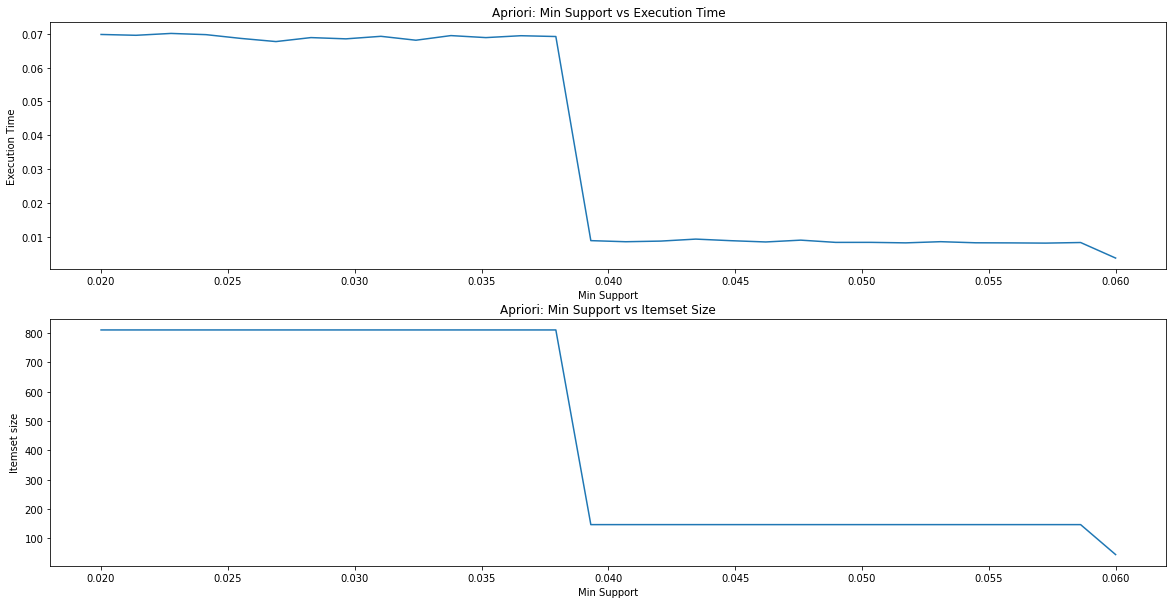

Average Execution time for Aprori: 0.03664385126636868


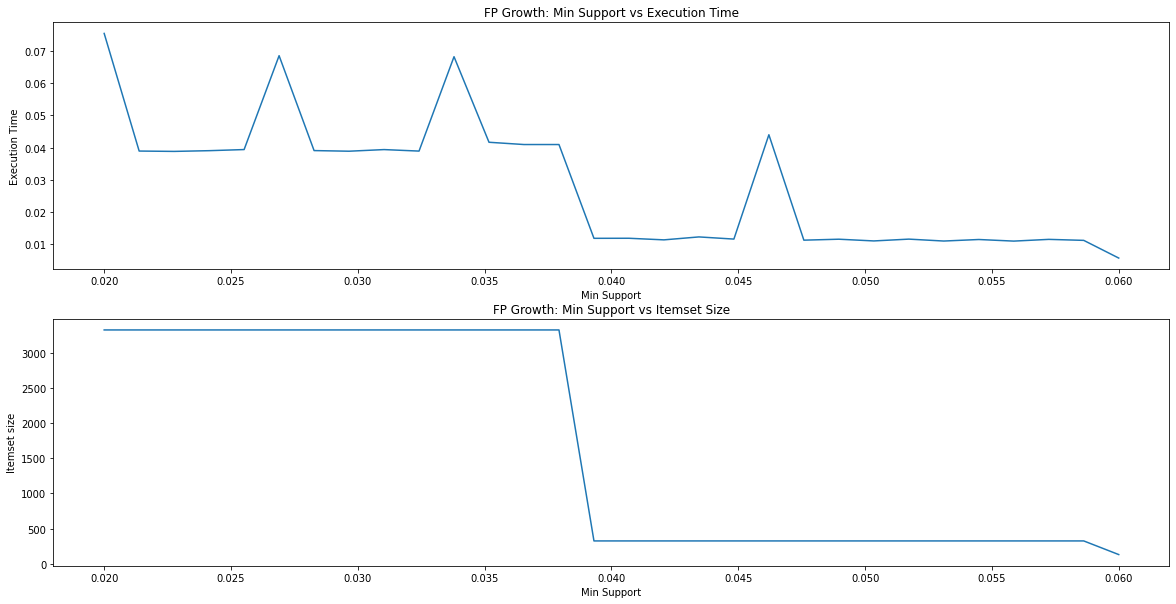

Average Execution time for FP Growth: 0.02860908930063791


In [28]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth

f_itemsets = apriori(df_trans_emo, min_support=0.04, use_colnames=True)

import time
import numpy as np
import matplotlib.pyplot as plt


def makePerfChart(df, algo, f):
    min_sups = np.linspace(0.02, 0.06, 30)
    e_times = []
    f_sizes = []

    for m in min_sups:
        t_1 = time.perf_counter()
        f_itemsets = f(df, min_support=m, use_colnames=True)
        t_2 = time.perf_counter()
        e_times.append(t_2 - t_1)
        f_sizes.append(f_itemsets.shape[0])

    fig, ax = plt.subplots(2, figsize=(20, 10))
    ax[0].plot(min_sups, e_times)
    ax[0].set(ylabel="Execution Time",xlabel="Min Support")

    ax[0].set_title("{}: Min Support vs Execution Time".format(algo))
    ax[1].plot(min_sups, f_sizes)
    ax[1].set(ylabel="Itemset size", xlabel="Min Support")
    ax[1].set_title("{}: Min Support vs Itemset Size".format(algo))
    plt.show()

    return e_times

e_times = makePerfChart(df_trans_emo, "Apriori", apriori)
print("Average Execution time for Aprori:", np.mean(e_times))
e_times = makePerfChart(df_trans_ei, "FP Growth", fpgrowth)
print("Average Execution time for FP Growth:", np.mean(e_times))

# Generate Association Rules

In [31]:
from mlxtend.frequent_patterns import association_rules
f_itemsets = fpgrowth(df_trans_ei, min_support=0.03793103, use_colnames=True)

rules = association_rules(f_itemsets, metric='lift', min_threshold=8.0, support_only=False)
rules.sort_values(by='lift', ascending=False, inplace=True)

# add dude with all zero recs
dict_either['hh26257'] = []

In [32]:
f_itemsets

,support,itemsets
0,0.117647,(1997.32)
1,0.098039,(P1976.13.2)
2,0.078431,(2003.154.1/19-19/19)
3,0.078431,(2017.1205)
4,0.078431,(G1976.21.7)
...,...,...
3320,0.039216,"(G1971.3.18, 1980.34, G1968.69)"
3321,0.039216,"(P1961.88, G1971.3.18, 1980.34)"
3322,0.039216,"(P1961.88, G1971.3.18, G1968.69)"
3323,0.039216,"(P1961.88, G1971.3.18, 1980.34, G1968.69)"


In [33]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8213,"(2013.9, 2016.108)","(1995.24, G1971.3.3, 1983.132.21/55, 1995.19)",0.039216,0.039216,0.039216,1.000000,25.5,0.037678,inf
9128,"(2013.9, 2016.108)","(1983.132.21/55, 2007.3, G1971.3.3, 1995.24, 1...",0.039216,0.039216,0.039216,1.000000,25.5,0.037678,inf
9118,"(2013.9, G1971.3.3, 1995.19)","(2007.3, 1995.24, 1983.132.21/55, 2016.108)",0.039216,0.039216,0.039216,1.000000,25.5,0.037678,inf
9119,"(2013.9, 1995.24, 1995.19)","(2007.3, G1971.3.3, 1983.132.21/55, 2016.108)",0.039216,0.039216,0.039216,1.000000,25.5,0.037678,inf
9120,"(G1971.3.3, 1995.24, 1995.19)","(2007.3, 2013.9, 1983.132.21/55, 2016.108)",0.039216,0.039216,0.039216,1.000000,25.5,0.037678,inf
...,...,...,...,...,...,...,...,...,...
14502,"(2018.195, P1967.1.19/20, 2016.102)",(1982.908),0.039216,0.117647,0.039216,1.000000,8.5,0.034602,inf
14498,(2005.151),"(1982.908, 1992.253.27/35, 2016.102)",0.117647,0.039216,0.039216,0.333333,8.5,0.034602,1.441176
14496,(1982.908),"(1992.253.27/35, 2005.151, 2016.102)",0.117647,0.039216,0.039216,0.333333,8.5,0.034602,1.441176
14489,"(1992.253.27/35, 2005.151, 2016.102)",(1982.908),0.039216,0.117647,0.039216,1.000000,8.5,0.034602,inf


In [34]:
def makeRecommendation(student_id, values, rules):
    if values:
        A_idx = rules['antecedents'].apply(lambda x: set(x) == set(values).intersection(set(x)))
        common_A = rules[['antecedents','consequents']].loc[A_idx]
    else:
        common_A = rules
    recs = set()
    seen_list = df_all[df_all['student_id'] == student_id]['Accession #'].to_list()
    
    for i,t in common_A['consequents'].items():
        for c in t:
            if (c not in seen_list):
                recs.add(c)
                if (len(recs) == 3):
                    return list(recs)
    print("[!] Failed to get 3 recs for student:", student_id, " seen_list: ", seen_list, " rec: ", recs)  
    return list(recs)

In [36]:
df_r = pd.DataFrame(columns=['student_id', 'recommendation 1', 'recommendation 2', 'recommendation 3'])
for i,(k, v) in enumerate(dict_either.items()):
    r = makeRecommendation(k, v, rules)
    df_r = df_r.append({'student_id':k, 'recommendation 1':r[0], 'recommendation 2':r[1], 'recommendation 3':r[2]}, ignore_index=True)
df_r.to_excel('student_recommentdations.xlsx', index=False)

In [38]:
df_r

,student_id,recommendation 1,recommendation 2,recommendation 3
0,AnaW4804,1987.17,G1975.1.59,2018.261
1,Frp323,1982.719,G1971.3.3,2006.294
2,ahasbany,1992.253.29/35,P1975.18.10/15,2017.1447
3,akp2597,2017.1112,2015.27,P1967.1.19/20
4,akshay17,1988.28,2017.1400,P1974.11.2
5,araman18,2017.93,G1974.6,1977.119
6,ashk2016,1982.719,2016.105,2006.294
7,ayan,1987.16,2018.195,2002.2846
8,benli,1991.210,2016.93,P1967.1.19/20
9,brandonn,1982.1342,2017.1409,2004.45
